In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from collections import OrderedDict
from inspect import getfullargspec
from scipy import (optimize as op, special, stats)

%matplotlib inline

In [49]:
from spectrum import Spectrum1D
wavelength, window = (6141.71, 10)

solar_spectrum = Spectrum1D.read("data/spectra/0_sun_n.fits")

# Take some data around the line.
idx = np.searchsorted(solar_spectrum.dispersion, 
                      [wavelength - window, wavelength + window])

x = solar_spectrum.dispersion[idx[0]:idx[1]]
y = solar_spectrum.flux[idx[0]:idx[1]]
y_err = np.abs(np.random.normal(0, 1e-3, size=y.size))

In [50]:
class Model(object):

    def __init__(self, wavelength, wavelength_tolerance=0.1, continuum_order=-1,
                 profile_type="gaussian", background_model_type="lognormal",
                 require_absorption_profile_as_foreground=False, **kwargs):

        profiles = dict(gaussian=gaussian, voigt=voigt)
        background_models = dict(lognormal=lognormal_lpdf, powerlaw=powerlaw_lpdf)

        try:
            self.profile = profiles[profile_type]

        except KeyError:
            raise ValueError(f"profile_type must be one of {profiles.keys()}")

        try:
            self.background_model = background_models[background_model_type]

        except KeyError:
            raise ValueError(f"background_model_type must be one of {background_models.keys()}")

        self.parameter_names = ["Q", "ln_intrinsic_scatter"] \
                             + getfullargspec(self.profile).args[1:] \
                             + getfullargspec(self.background_model).args[1:] \
                             + ["continuum_coefficients"]
        self.continuum_order = continuum_order
        self.require_absorption_profile_as_foreground = require_absorption_profile_as_foreground

        self.parameter_bounds = dict(Q=[0, 1],
                                     amplitude=[0, 1],
                                     sigma=[0, np.inf],
                                     fwhm=[0, np.inf],
                                     x0=[
                                        wavelength - wavelength_tolerance,
                                        wavelength + wavelength_tolerance
                                     ],
                                     shape=[0, np.inf],
                                     lognormal_shape=[1, 100],
                                     ln_intrinsic_scatter=[-30, -5])

        return None


    def pack(self, *parameters):
        packed = OrderedDict()
        for name, value in zip(self.parameter_names, parameters):
            packed[name] = value
        
        last_parameter = self.parameter_names[-1]
        P, N = (len(parameters), len(self.parameter_names))
        if P >= N:
            # Pack remaining into the last parameter name
            packed[last_parameter] = parameters[N-1:]

        packed.setdefault(last_parameter, [])
        packed[last_parameter] = np.atleast_1d(packed[last_parameter])

        return packed


    def unpack(self, parameters):
        return np.hstack([parameters[k] for k in self.parameter_names])


    def ln_prior(self, x, parameters, full_output=False, **kwargs):

        theta = self.pack(*parameters)
        for k, (lower, upper) in self.parameter_bounds.items():
            if k in theta and not (upper >= theta[k] >= lower):
                return -np.inf if not full_output \
                               else (-np.inf, k, theta[k], lower, upper)

        c = self.continuum(x, **theta)
        if np.any(c < 0):
            return -np.inf if not full_output \
                           else (-np.inf, "continuum", c, 0, np.inf)

        return 0


    def continuum(self, x, continuum_coefficients, **kwargs):
        if not len(continuum_coefficients):
            return np.ones_like(x)
        return np.polyval(continuum_coefficients, x)


    def __call__(self, x, parameters, **kwargs):
        theta = self.pack(*parameters)
        return self.continuum(x, **theta) * (1 - self.profile(x, **theta))


    def ln_likelihood(self, x, y, y_err, parameters, **kwargs):

        theta = self.pack(*parameters)
        c = self.continuum(x, **theta)

        foreground = c * (1 - self.profile(x, **theta))

        Q = theta["Q"]
        # TODO: use intrinsic scatter?
        #s = np.sqrt(y_err**2 + np.exp(2 * theta["ln_intrinsic_scatter"]))
        s = y_err
        foreground_ll = np.log(Q) + stats.norm.logpdf(y, foreground, s)
        background_ll = np.log(1 - Q) + self.background_model(y/foreground, **theta)

        if self.require_absorption_profile_as_foreground:
            min_ll = np.nanmin(np.hstack([foreground_ll, background_ll]))
            in_line = np.abs(x - theta["x0"]) <= (2 * theta.get("sigma", theta.get("fwhm")))
            background_ll[in_line] = min_ll

        ll = np.sum(np.logaddexp(foreground_ll, background_ll))
        if kwargs.get("full_output", False):
            return (ll, foreground_ll, background_ll, foreground, c)

        return ll


    def initial_guess(self, x, y, y_err):

        if self.continuum_order >= 0:
            # TODO: thinko
            #continuum_coefficients = np.polyfit(x, y, self.continuum_order)
            continuum_coefficients = np.hstack([np.median(y), np.zeros(self.continuum_order)])[::-1]
        else:
            continuum_coefficients = []

        return self.unpack(dict(Q=1.0,
                                x0=np.mean(self.parameter_bounds["x0"]),
                                amplitude=1 - y[int(y.size/2)],
                                sigma=0.05,
                                ln_intrinsic_scatter=-9,
                                powerlaw_shape=5.5,
                                fwhm=2.35 * 0.05,
                                shape=0.05,
                                lognormal_shape=np.mean(self.parameter_bounds["lognormal_shape"]),
                                continuum_coefficients=continuum_coefficients))


    def ln_probability(self, x, y, y_err, parameters, **kwargs):
        lp = self.ln_prior(x, parameters, **kwargs)
        if not np.isfinite(lp): return lp

        return lp + self.ln_likelihood(x, y, y_err, parameters, **kwargs)

    
    def p_outlier(self, x, y, y_err, parameters, **kwargs):
        ll, f_ll, b_ll, f, c = self.ln_likelihood(x, y, y_err, parameters, 
                                                  full_output=True)
        return np.exp(f_ll - np.logaddexp(f_ll, b_ll))




def powerlaw_lpdf(y, powerlaw_shape, **kwargs):
    return stats.powerlaw.logpdf(y, powerlaw_shape)

def lognormal_lpdf(y, lognormal_shape, **kwargs):
    return stats.lognorm.logpdf(1 - y, lognormal_shape)

def gaussian(x, x0, amplitude, sigma, **kwargs):
    return amplitude * np.exp(-(x - x0)**2 / (2.0 * sigma**2))


def voigt(x, x0, amplitude, fwhm, shape, **kwargs):
    N = np.atleast_1d(x).size    
    y = 1 / special.wofz(np.zeros(N) + 1j * np.sqrt(np.log(2.0)) * shape).real
    return y * amplitude * special.wofz(2*np.sqrt(np.log(2.0)) * (x - x0)/fwhm \
             + 1j * np.sqrt(np.log(2.0))*shape).real


In [51]:
options = dict(wavelength=wavelength, 
               continuum_order=2,
               profile_type="gaussian", 
               background_model_type="lognormal",
               require_absorption_profile_as_foreground=False)

model = Model(**options)

p0 = model.initial_guess(x, y, y_err)
nlp = lambda p: -model.ln_probability(x, y, y_err, p)

p_opt = op.minimize(nlp, p0, method="Powell")
assert p_opt.success

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in log
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


In [52]:
# Re-run without absorption profile constraint (sometimes useful for voigt profiles)
model = Model(**{**options, **dict(require_absorption_profile_as_foreground=False)})

nlp = lambda p: -model.ln_probability(x, y, y_err, p)

p_opt = op.minimize(nlp, p_opt.x, method="Powell")
assert p_opt.success


/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


In [53]:
theta_opt = model.pack(*p_opt.x)
for k, v in theta_opt.items():
    print(f"{k}: {v}")

Q: 0.003347250568570689
ln_intrinsic_scatter: -6.412071038407198
x0: 6141.713946320487
amplitude: 0.7081729338573199
sigma: 0.05912186206762311
lognormal_shape: 4.247285387181406
continuum_coefficients: [ 3.33963141e-10 -1.54861837e-08  9.89834569e-01]


In [54]:
#model.pack(*p0)

In [55]:
print(p_opt)

   direc: array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.]])
     fun: -2330.3383351361963
 message: 'Optimization terminated successfully.'
    nfev: 392
     nit: 1
  status: 0
 success: True
       x: array([ 3.34725057e-03, -6.41207104e+00,  6.14171395e+03,  7.08172934e-01,
        5.91218621e-02,  4.24728539e+00,  3.33963141e-10, -1.54861837e-08,
        9.89834569e-01])


(6131.7199903388555, 6151.7002533304585)

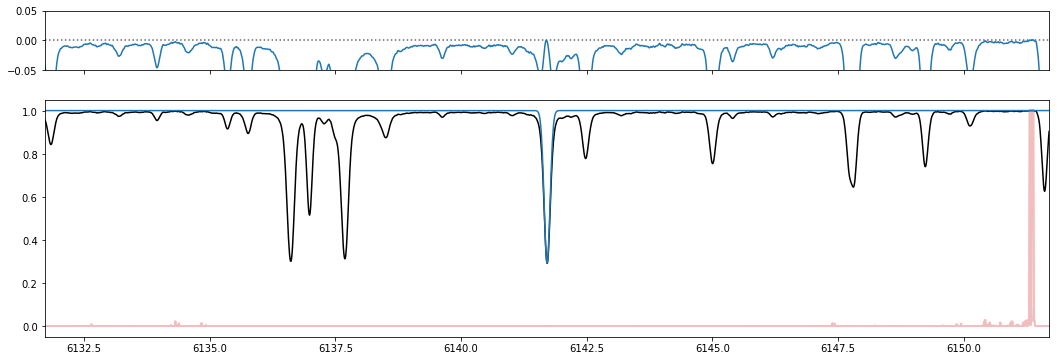

In [56]:
p = model.p_outlier(x, y, y_err, p_opt.x)

fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4], figure=fig)

ax_resid = plt.subplot(gs[0])
ax_data = plt.subplot(gs[1])

ax_resid.axhline(0, c="#666666", linestyle=":", zorder=-1)
ax_resid.plot(x, y - model(x, p_opt.x), c="tab:blue")
ax_resid.set_ylim(-0.05, 0.05)
ax_resid.set_xlim(x[0], x[-1])
ax_resid.set_xticklabels([])

ax_data.plot(x, y, c="k")
#ax_data.plot(x, model(x, p0), c="tab:green")
ax_data.plot(x, model(x, p_opt.x), c="tab:blue")
ax_data.plot(x, p, c="tab:red", zorder=-1, lw=2, alpha=0.3)
ax_data.set_xlim(x[0], x[-1])
#ax_data.set_ylim(0.8, 1.1)